## Import Libraries
Here, we import the necessary libraries for data processing and visualization. We also set some data formatting rules to get rid of long decimals/floats.

In [371]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import os
from tensorflow.keras.models import load_model

pd.options.display.float_format = "{:.3f}".format
np.set_printoptions(formatter={'float': lambda x: '{:.3f}'.format(x)})

## Set hyperparameters
Include list of phonemes + silence.


In [372]:
# X_train.shape = [N, CHANNELS, SIZE]
# Filename format - X_PHONEMES_N_CHANNELS_SIZE_STEP.npy
PHONEMES = ['_', 'h', 'j', 'l', 'n', 'r', 'w', 'y', 'ch', 'sh', 'ng', 'th(e)', 'th(in)', 'zh', 'wh', 'ā(r)', 'i(r)', 'o(r)', 'u(r)', 'ō', 'o', 'ōō', 'ow']
CHANNELS = 4
SIZE = 5
STEP = 5

## Define plot_all_channels Function
Define a function `plot_all_channels` that takes a DataFrame and a title as inputs, and creates a figure with subplots for each channel.

In [373]:
def plot_all_channels(df, title, tick_gap = 20000): # Create a figure and subplots for each channel
  fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(10, 10), sharex=True)

  for i, channel in enumerate(column_names):
      if channel != 'TIMESTAMP':
        axes[i].plot(df[channel], label=channel)
        axes[i].set_ylabel(channel)
        axes[i].legend(loc="upper left")

  # plt.xticks(list(range(0, len(df), tick_gap)))

  # Set the x-axis label and title for the entire figure
  plt.xlabel("Sample Index")
  plt.suptitle(title)

  # Display the plot
  plt.show()

## Load Data
Load the CSV data into a Pandas dataframe and get some information on its shape and columns.


In [374]:
# Update the file path below with the path to your CSV file
csv_file_path = "data.csv"

# Read the CSV data into a Pandas DataFrame
df_og = pd.read_csv(csv_file_path, skiprows=4)

print(f"df_og.shape:{df_og.shape}")
print(f"df_og.columns:{df_og.columns}")

df_og.shape:(97423, 25)
df_og.columns:Index(['Sample Index', ' EXG Channel 0', ' EXG Channel 1', ' EXG Channel 2',
       ' EXG Channel 3', ' EXG Channel 4', ' EXG Channel 5', ' EXG Channel 6',
       ' EXG Channel 7', ' Accel Channel 0', ' Accel Channel 1',
       ' Accel Channel 2', ' Other', ' Other.1', ' Other.2', ' Other.3',
       ' Other.4', ' Other.5', ' Other.6', ' Analog Channel 0',
       ' Analog Channel 1', ' Analog Channel 2', ' Timestamp', ' Other.7',
       ' Timestamp (Formatted)'],
      dtype='object')


## Preprocess Data
Filter to only keep relevant columns, replace timestamps with a 4ms incerment since we know that's the recording frequency.

In [375]:
# Select the columns from index 1 to 5 and column index 22, then concatenate the resulting DataFrames horizontally (axis=1)
df_filtered = pd.concat([df_og.iloc[:, 1:6], df_og.iloc[:, 22]], axis=1)
# df = df_og

# Assign new column names (ZYG, DLI, OOS, OOI, BUTTON, TIMESTAMP)
column_names = ['RIS', 'LLS', 'PLA', 'OOI', 'BUTTON', 'TIMESTAMP']
df_filtered.columns = column_names

df_filtered['TIMESTAMP'] = [i*4 for i in range(0, len(df_filtered))]

df_filtered

,RIS,LLS,PLA,OOI,BUTTON,TIMESTAMP
0,0.000,0.000,0.000,0.000,0.000,0
1,-20705.047,-25089.386,-10603.846,5658.389,-636.756,4
2,-20706.656,-25090.459,-10604.919,5654.634,-637.829,8
3,-20708.802,-25092.605,-10607.601,5653.024,-637.829,12
4,-20707.729,-25092.605,-10610.820,5655.170,-637.829,16
...,...,...,...,...,...,...
97418,-15704.872,-33278.171,-7968.844,27991.537,-635.684,389672
97419,-15702.726,-33279.244,-7964.552,27989.391,-637.829,389676
97420,-15704.872,-33277.635,-7969.380,27985.099,-636.756,389680
97421,-15702.190,-33276.562,-7976.354,27987.782,-636.756,389684


## Plot Raw EXG Channels
Plot the raw EXG channels using the `plot_all_channels` function.

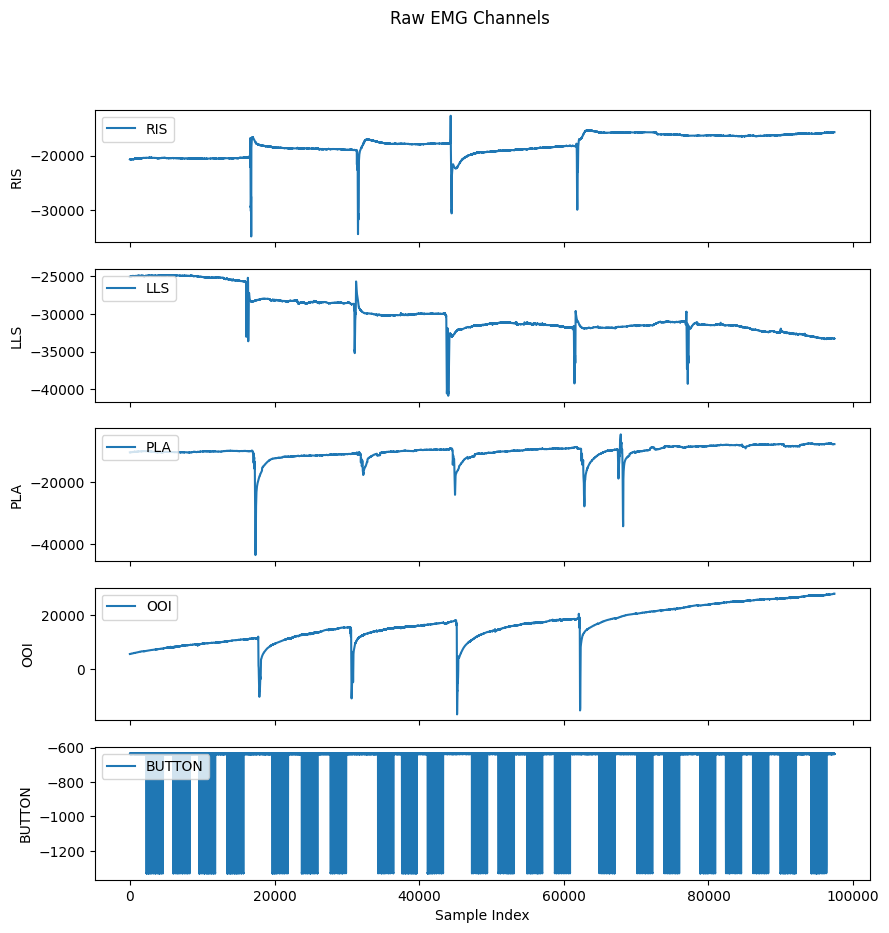

In [376]:
# Remove first 10 rows because of bad data
CUTOFF = 10
df = df_filtered.iloc[CUTOFF:]

df = df.reset_index(drop=True)

# Plot
plot_all_channels(df, "Raw EMG Channels")

## Outlier Removal and Data Normalization
Manually cut out outliers, and normalize the data using Min-Max normalization, round "BUTTON" values to 0 or 1, flip them so they're the right way around, and create a new DataFrame `df_normalized`.

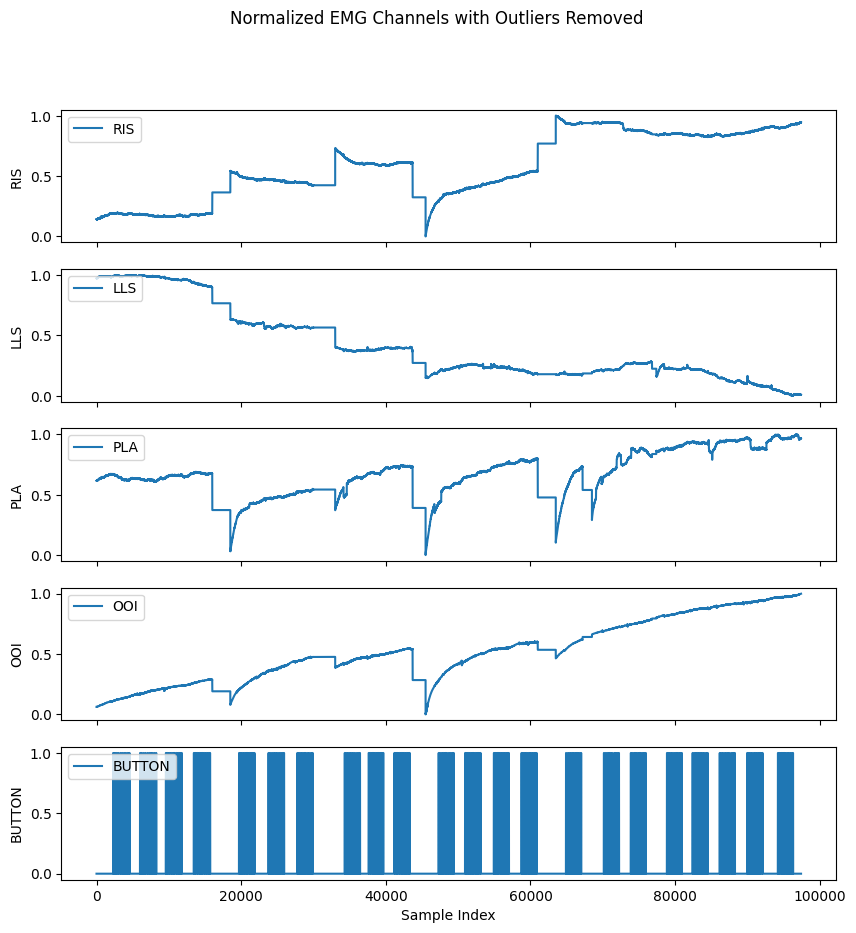

In [377]:
# Backup the "TIMESTAMP" column before removing outliers and normalization
timestamp_col = df["TIMESTAMP"].copy()

LEFT_PAD = 0
RIGHT_PAD = 0
AVG_PAD = 200
# Manually remove outliers by replacing with mean of surrounding values
df.iloc[16000-LEFT_PAD:18500+RIGHT_PAD] = df.iloc[np.r_[16000-AVG_PAD:16000, 18500:18500+AVG_PAD]].mean()
df.iloc[30000-LEFT_PAD:33000+RIGHT_PAD] = df.iloc[np.r_[30000-AVG_PAD:30000, 30000:30000+AVG_PAD]].mean()
df.iloc[43700-LEFT_PAD:45500+RIGHT_PAD] = df.iloc[np.r_[43700-AVG_PAD:43700, 45500:45500+AVG_PAD]].mean()
df.iloc[61000-LEFT_PAD:63500+RIGHT_PAD] = df.iloc[np.r_[61000-AVG_PAD:61000, 63500:63500+AVG_PAD]].mean()
df.iloc[67200-LEFT_PAD:68500+RIGHT_PAD] = df.iloc[np.r_[67200-AVG_PAD:67200, 68500:68500+AVG_PAD]].mean()
df.iloc[76800-LEFT_PAD:77400+RIGHT_PAD] = df.iloc[np.r_[76800-AVG_PAD:76800, 77400:77400+AVG_PAD]].mean()

# Drop the "TIMESTAMP" column before normalizing
df_no_timestamp = df.drop("TIMESTAMP", axis=1)

# Normalize the data using Min-Max normalization
df_normalized = (df_no_timestamp - df_no_timestamp.min()) / (df_no_timestamp.max() - df_no_timestamp.min())

# Round "BUTTON" values to 0 or 1
df_normalized["BUTTON"] = df_normalized["BUTTON"].round()

# Flip values for convenience
df_normalized['BUTTON'] = df_normalized['BUTTON'].apply(lambda x: 1 if x == 0 else 0)

# Re-insert the "TiTIMESTAMPmestamp" column
df_normalized.insert(0, "TIMESTAMP", timestamp_col)

# Plot
plot_all_channels(df_normalized, "Normalized EMG Channels with Outliers Removed")

## Define plot_rolling_channel_4 and segment_stats Functions
Define two functions: `plot_rolling_channel_4` for plotting the rolling maximum of "BUTTON" with different ranges, and `segment_stats` for calculating statistics about the segments.

In [378]:
def plot_rolling_channel_4(title, tick_gap = 2500, start=None, end=None, df = df_normalized):
  # # Do proper data cut based on arguments
  if start is None:
    start = 0
  if end is None:
    end = len(df)

  # Plot the original data and the rolling mean on a number line
  plt.figure(figsize=(16, 4))
  # plt.plot(df.index, df['EXG Channel 4'], label='Original Data', alpha=0.5)
  plt.plot(df[start:end].index, df['rolling_max'][start:end], linewidth=1)
  plt.xlabel('Index')
  plt.ylabel('Activation')

  plt.xticks(list(range(start, end, tick_gap)))

  plt.title(title)
  plt.show()

def segment_stats(df, segments):
    # Calculate statistics about the list of segments
    num_segments = len(segments)  # Number of segments
    segment_lengths = [end - start for start, end in segments]  # Lengths of each segment in terms of indices

    # Calculate the average segment length
    average_length = np.around(np.mean(segment_lengths), 2)

    # Calculate the minimum and maximum segment length
    min_length = np.min(segment_lengths)
    max_length = np.max(segment_lengths)

    # Calculate the segment lengths in terms of time (milliseconds) using the "TIMESTAMP" column
    segment_lengths_ms = [(df.loc[end, 'TIMESTAMP'] - df.loc[start, 'TIMESTAMP']) for start, end in segments]

    # Calculate the mean, min, and max segment lengths in milliseconds
    mean_length_ms = np.around(np.mean(segment_lengths_ms), 2)
    min_length_ms = np.around(np.min(segment_lengths_ms), 2)
    max_length_ms = np.around(np.max(segment_lengths_ms), 2)

    # Print the statistics
    print(f"\nSegments: {segments}")
    print(f"Number of segments: {num_segments}")
    print(f"Average segment length: {average_length} values")
    print(f"Minimum segment length: {min_length} values")
    print(f"Maximum segment length: {max_length} values")
    print(f"Average segment length (ms): {mean_length_ms} ms")
    print(f"Minimum segment length (ms): {min_length_ms} ms")
    print(f"Maximum segment length (ms): {max_length_ms} ms")

## Add Rolling Max Column (Smooth Out Data)
Add a new column to the DataFrame `df_normalized` for the rolling maximum of "BUTTON" with a window size of rolling_window_size.

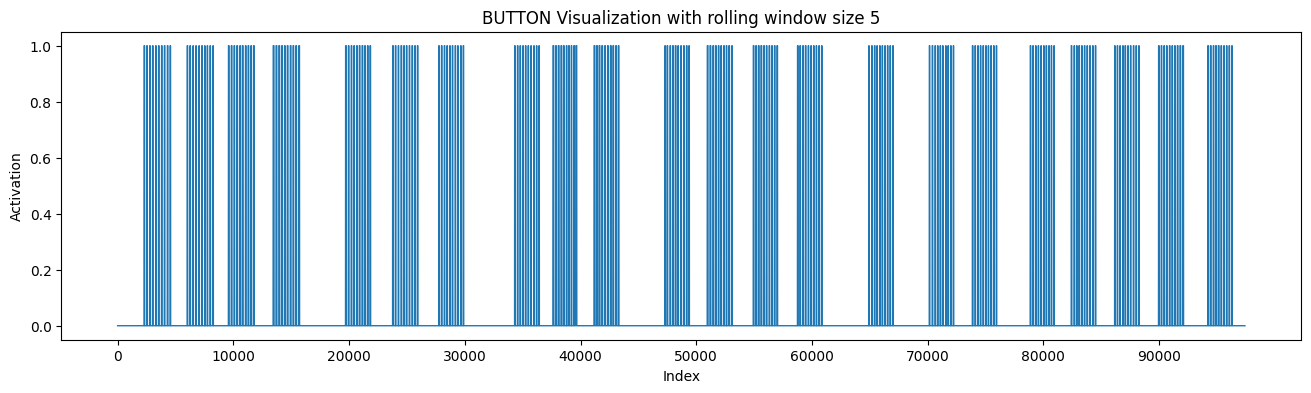

In [379]:
rolling_window_size = 5

# Make rolling max column
df_normalized['rolling_max'] = df_normalized['BUTTON'].rolling(window=rolling_window_size, center=True).max()

# Plot
plot_rolling_channel_4(f"BUTTON Visualization with rolling window size {rolling_window_size}", tick_gap = 10000)

## Identify Segments
Identify the start and end indices of segments with 1s in the rolling maximum of "BUTTON".

In [380]:
# Add a new column to the dataframe to identify the change in segments between 0s and 1s
df_normalized['segment_change'] = df_normalized['rolling_max'].diff()

# Identify the start and end indices of the segments with 1s
start_indices = df_normalized[df_normalized['segment_change'] == 1].index.tolist()
end_indices = df_normalized[df_normalized['segment_change'] == -1].index.tolist()

# If the first segment starts with 1s, add the starting index to the list
first_index = df_normalized.index[0]  # Get the first index of the dataframe
if df_normalized.loc[first_index, 'rolling_max'] == 1:
    start_indices.insert(0, first_index)

# If the last segment ends with 1s, add the last index to the list
last_index = df_normalized.index[-1]  # Get the last index of the dataframe
if df_normalized.loc[last_index, 'rolling_max'] == 1:
    end_indices.append(last_index)

# Combine the start and end indices into pairs
segments = list(zip(start_indices, end_indices))

# Get segments that need to be zeroed
segments_to_delete = [(start, end) for start, end in segments if end - start < 20]

# Filter out small segments
segments = [(start, end) for start, end in segments if end - start >= 20]

print(f"segments: {segments}")
print(f"len(segments): {len(segments)}")

segments: [(2285, 2328), (2516, 2562), (2767, 2811), (3015, 3052), (3287, 3323), (3531, 3572), (3790, 3828), (4035, 4074), (4293, 4339), (4531, 4573), (6007, 6047), (6249, 6288), (6514, 6541), (6758, 6792), (7027, 7058), (7271, 7311), (7516, 7544), (7742, 7773), (7986, 8018), (8232, 8265), (9572, 9626), (9818, 9874), (10062, 10104), (10297, 10357), (10561, 10610), (10778, 10835), (11043, 11092), (11274, 11324), (11513, 11558), (11742, 11800), (13437, 13509), (13685, 13753), (13929, 13996), (14174, 14229), (14418, 14472), (14657, 14717), (14916, 14975), (15158, 15207), (15401, 15455), (15651, 15715), (19693, 19757), (19937, 19982), (20181, 20227), (20414, 20459), (20658, 20705), (20882, 20934), (21118, 21179), (21352, 21398), (21587, 21635), (21808, 21855), (23760, 23811), (23996, 24038), (24249, 24281), (24489, 24538), (24733, 24770), (24950, 24989), (25199, 25235), (25440, 25481), (25681, 25720), (25899, 25941), (27746, 27791), (27978, 28020), (28223, 28262), (28455, 28495), (28695, 2

## Seperate Segments
Seperate segmentd into seperate phoneme groupings based on distance apart from each other.

In [381]:
def group_segments(segments, gap, phonemes):
  groups = {}
  current_group = []

  i = 0

  for segment in segments:
      if not current_group:
          current_group.append(segment)
      else:
          last_segment = current_group[-1]

          # Check if the next segment starts after a gap of at least 1000
          if segment[0] > last_segment[1] + gap:
              groups[phonemes[i]] = (current_group)
              i += 1
              current_group = [segment]
          else:
              current_group.append(segment)

  # Appending the last group to the list of groups
  if current_group:
      groups[phonemes[i]] = (current_group)

  return groups

segment_dict = group_segments(segments, 1000, PHONEMES[1:])

print(f"Total phonemes - len(segment_dict): {len(segment_dict)}")
print(f"Recordings per phoneme: {[len(segment_dict[x]) for x in PHONEMES[1:]]}")

Total phonemes - len(segment_dict): 22
Recordings per phoneme: [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]


## Plot and Calculate Segment Statistics
Plot and analyze different segments of the data using the `plot_rolling_channel_4` and `segment_stats` functions.

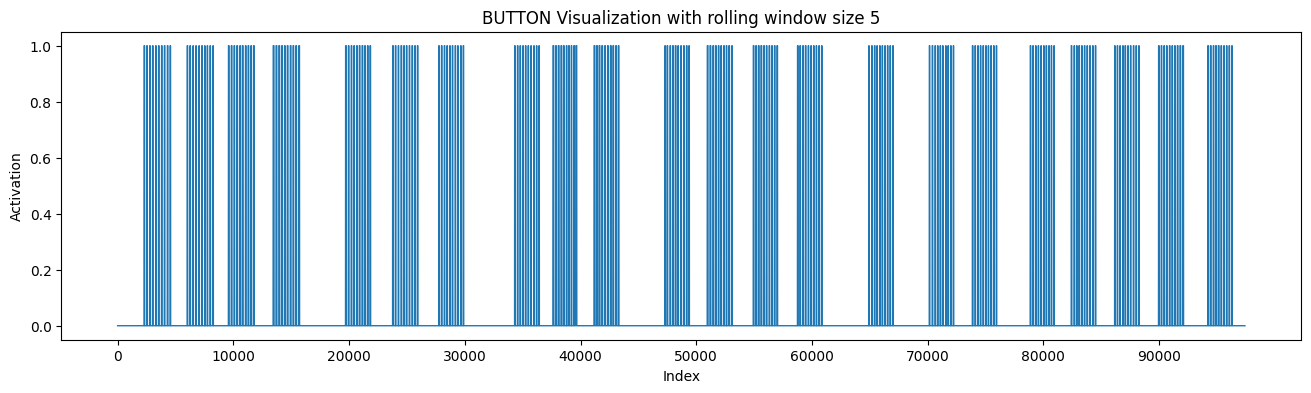


Segments: [(2285, 2328), (2516, 2562), (2767, 2811), (3015, 3052), (3287, 3323), (3531, 3572), (3790, 3828), (4035, 4074), (4293, 4339), (4531, 4573), (6007, 6047), (6249, 6288), (6514, 6541), (6758, 6792), (7027, 7058), (7271, 7311), (7516, 7544), (7742, 7773), (7986, 8018), (8232, 8265), (9572, 9626), (9818, 9874), (10062, 10104), (10297, 10357), (10561, 10610), (10778, 10835), (11043, 11092), (11274, 11324), (11513, 11558), (11742, 11800), (13437, 13509), (13685, 13753), (13929, 13996), (14174, 14229), (14418, 14472), (14657, 14717), (14916, 14975), (15158, 15207), (15401, 15455), (15651, 15715), (19693, 19757), (19937, 19982), (20181, 20227), (20414, 20459), (20658, 20705), (20882, 20934), (21118, 21179), (21352, 21398), (21587, 21635), (21808, 21855), (23760, 23811), (23996, 24038), (24249, 24281), (24489, 24538), (24733, 24770), (24950, 24989), (25199, 25235), (25440, 25481), (25681, 25720), (25899, 25941), (27746, 27791), (27978, 28020), (28223, 28262), (28455, 28495), (28695, 

In [382]:
plot_rolling_channel_4(f"BUTTON Visualization with rolling window size {rolling_window_size}", tick_gap = 10000)
segment_stats(df_normalized, segments)

# Clean Dataframe
Remove unneeded columns.

In [383]:
df_final = df_normalized.drop(['TIMESTAMP', 'BUTTON', 'rolling_max', 'segment_change'], axis=1)
df_final.head()

,RIS,LLS,PLA,OOI
0,0.143,0.973,0.616,0.062
1,0.142,0.972,0.616,0.062
2,0.142,0.972,0.616,0.062
3,0.142,0.972,0.616,0.062
4,0.142,0.973,0.616,0.062


# Create Silent Segments
Pick an area with no recording/EMG activation, and generate even sections as silence class training examples.

In [384]:
NUM_SILENT_SEGMENTS = 50

def generate_even_segments(segment_size, segment_count, start_index, end_index):
    segments = []
    total_length = segment_size * segment_count

    # Calculate the range between start_index and end_index
    max_range = end_index - start_index

    # Calculate the overlap or gap between segments
    overlap_gap = (total_length - max_range) // (segment_count - 1) if segment_count > 1 else 0

    for i in range(segment_count):
        start_index_segment = start_index + i * (segment_size - overlap_gap)  # Calculate start_index for each segment based on overlap or gap
        end_index_segment = start_index_segment + segment_size

        segments.append((start_index_segment, end_index_segment))

    return segments

# Between 0 and 2000
segments_silence = generate_even_segments(10, NUM_SILENT_SEGMENTS, 0, 2000)
# segments_silence_2 = generate_even_segments(10, 20, 30000, 32000)
# segments_silence_3 = generate_even_segments(10, 20, 61000, 63000)
# segments_silence = segments_silence_1 + segments_silence_2 + segments_silence_3
len(segments_silence)

50

## Segment Data
Split the actual dataframes into the segment chunks, store in dictionary.

In [385]:
# Create recording arrays from df and array of (start, end) segments
def segment_data(df, segments):
  data_segments = []
  for start, end in segments:
    segment = df.iloc[start:end].to_numpy()
    data_segments.append(segment)
  return data_segments

data_segments = segment_data(df_final, segments)

data_segments_silence = segment_data(df_final, segments_silence)

data_segments_dict = dict(segment_dict)

total = 0
for key in segment_dict.keys():
  segs_num = len(segment_dict[key])

  data_segments_dict[key] = data_segments[total:total+segs_num]

  total += segs_num

print(f"len(data_segments_dict): {len(data_segments_dict)}")

len(data_segments_dict): 22


## Generate Training Examples/Labels
Using a sliding window technique, create multiple training examples from each segment, concatenate to create X_train, then create appropriate y_train array.


In [386]:
def generate_training_examples(data_segments, SIZE, STEP):
  training_examples = []

  for segment in data_segments:
    start_index = 0
    end_index = start_index + SIZE

    while end_index <= len(segment):
      example = segment[start_index:end_index]
      training_examples.append(example)

      start_index += STEP
      end_index += STEP

  return training_examples

# Generate training examples for each phoneme and silence
train_dict = dict([(key, generate_training_examples(data_segments_dict[key], SIZE, STEP)) for key in segment_dict.keys()])

train_silence = generate_training_examples(data_segments_silence, SIZE, STEP)
print(f"# silence: {len(train_silence)}")

for key in train_dict.keys():
  print(f"# {key}: {len(train_dict[key])}")

# Concatenate training arrays
def concatenate_lists(dictionary):
    result = []  # Create empty list to store the concatenated lists

    # Loop over the values of the dictionary
    for value_list in dictionary.values():
        # Extend the result list instead of appending to flatten the list of lists
        result.extend(value_list)

    return result  # Return the concatenated lists

X_train = train_silence + concatenate_lists(train_dict)
X_train = np.transpose(np.array(X_train), (0, 2, 1))

print(f"\nX_train.shape: {X_train.shape} - {X_train.shape[0]} training examples, {X_train.shape[1]} channels (muscle groups) per example, each {X_train.shape[2]} timesteps long")

# Generate training labels for each phoneme and silence
y_train_silence = np.full(len(train_silence), 0)

# Generate the labels for the keys in train_dict using a dictionary comprehension
# The keys need to be integers, so use enumerate() to assign an index (starting from 1)
y_train_dict = {key: np.full(len(train_dict[key]), i + 1) for i, key in enumerate(train_dict.keys())}

# Concatenate the labels
def concatenate_labels(labels_dict, first_label_array):
    result = first_label_array.tolist()  # Convert the first_label_array to a list

    # Loop over the values (arrays) of the labels_dict
    for label_array in labels_dict.values():
        # Extend the result list with the elements of the label_array converted to list
        result.extend(label_array.tolist())

    return np.array(result)  # Convert the result list to an array and return it

y_train = concatenate_labels(y_train_dict, y_train_silence)

print(f"y_train.shape: {y_train.shape} - {y_train.shape[0]} training labels")

# silence: 100
# h: 78
# j: 63
# l: 100
# n: 115
# r: 97
# w: 77
# y: 73
# ch: 67
# sh: 110
# ng: 114
# th(e): 81
# th(in): 100
# zh: 93
# wh: 80
# ā(r): 66
# i(r): 66
# o(r): 66
# u(r): 70
# ō: 71
# o: 63
# ōō: 88
# ow: 85

X_train.shape: (1923, 4, 5) - 1923 training examples, 4 channels (muscle groups) per example, each 5 timesteps long
y_train.shape: (1923,) - 1923 training labels


## Create Filename
Set filename based on hyperparameters.

In [387]:
# X_train.shape = [N, CHANNELS, SIZE]
# Filename format - _PHONEMES_N_CHANNELS_SIZE_STEP.npy

N = len(X_train)
filename = f"_last22_{N}_{CHANNELS}_{SIZE}_{STEP}_final.npy"

## Save Files

In [388]:
print(filename)
np.save(f"./X{filename}", X_train)
np.save(f"./y{filename}", y_train)

_last22_1923_4_5_5_final.npy


--------------------------------------------------------------------------------
# Model Testing Script
--------------------------------------------------------------------------------

## Load Model
Load model files from Google Drive

In [392]:
def get_files_with_prefix(directory, prefix):
    files = os.listdir(directory)
    filtered_files = [file for file in files if file.startswith(prefix)]
    return filtered_files

directory = "/content/drive/MyDrive/"
filename = get_files_with_prefix(directory, f"LSTM_last22_seed351_5_5_final")[0]

# Load the model
model = load_model("drive/MyDrive/" + filename)

## Split Recording Into Frames
Process raw recording data into window frames (transposed to fit into model) that can be evaluated in order.

In [393]:
def preprocess(dataframe):
  training_examples = []

  start_index = 0
  end_index = start_index + SIZE

  while end_index <= len(dataframe):
    example = np.transpose(np.array(dataframe[start_index:end_index]))
    training_examples.append(example)

    start_index += STEP
    end_index += STEP

  return training_examples

df_final_raw = df_filtered.drop(['TIMESTAMP', 'BUTTON'], axis=1)[10:]
df_final_raw = (df_final_raw - df_final_raw.min()) / (df_final_raw.max() - df_final_raw.min())

# Preprocess the input data
input_data = np.array(preprocess(df_final))

# Reshape data
input_data = input_data.reshape(-1, CHANNELS, SIZE)

# Print the shape
print(f"len(input_data): {len(input_data)}")
print(f"input_data[0].shape: {input_data[0].shape}")

len(input_data): 19482
input_data[0].shape: (4, 5)


## Evaluate
Evaluate the model on the recording.

In [394]:
# Get prediction probabilities
predictions = model.predict(input_data)

# Convert probabilities into phonemes
phoneme_stream = np.array(PHONEMES)[np.argmax(predictions, axis=1)]

# Print phoneme_stream
print(f"phoneme_stream: {phoneme_stream}")

609/609 [==============================] - 5s 7ms/step
phoneme_stream: ['_' '_' '_' ... 'ow' 'ow' 'ow']


## Predicition Statistics
Calculate phoneme prediction counts and percentages, then print.

In [395]:
from collections import Counter
y_og_counts = Counter(phoneme_stream)
y_og_counts

# 1. Calculate the total amount of phonemes
total_phonemes = sum(y_og_counts.values())

# 2. Create a new dictionary to store the percentages
y_og_percentages = {}

# 3. Iterate through the keys in y_og_counts and calculate the percentage for each phoneme
for phoneme, count in y_og_counts.items():
    percentage = (count / total_phonemes) * 100
    y_og_percentages[phoneme] = percentage

# 4. Display the resulting percentages
for phoneme, percentage in y_og_percentages.items():
    print(f"{phoneme}: {y_og_counts[phoneme]}/{total_phonemes}  |   {percentage:.2f}%")

_: 482/19482  |   2.47%
h: 546/19482  |   2.80%
j: 773/19482  |   3.97%
l: 702/19482  |   3.60%
n: 697/19482  |   3.58%
r: 1532/19482  |   7.86%
w: 873/19482  |   4.48%
y: 1108/19482  |   5.69%
ch: 1249/19482  |   6.41%
sh: 490/19482  |   2.52%
ng: 761/19482  |   3.91%
th(e): 801/19482  |   4.11%
th(in): 687/19482  |   3.53%
zh: 868/19482  |   4.46%
wh: 631/19482  |   3.24%
ā(r): 1616/19482  |   8.29%
ōō: 795/19482  |   4.08%
i(r): 670/19482  |   3.44%
o(r): 936/19482  |   4.80%
u(r): 869/19482  |   4.46%
o: 894/19482  |   4.59%
ō: 653/19482  |   3.35%
ow: 849/19482  |   4.36%


## Visualize Predictions
Check and vizualize predictions.

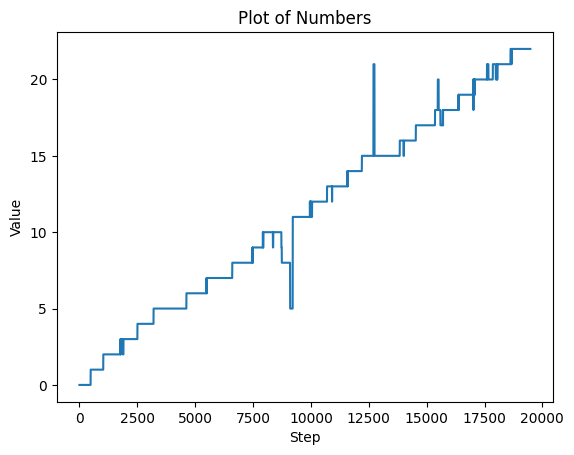

In [396]:
x_values = list(range(len(phoneme_stream)))

# Plot the X and Y values
plt.plot(x_values, np.argmax(predictions, axis=1))

# Add title, X-axis, and Y-axis labels
plt.title("Plot of Numbers")
plt.xlabel("Step")
plt.ylabel("Value")

# Display the plot
plt.show()